In [6]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [17]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt

from src.data_utils import get_emnist_dataloaders, get_num_classes
from src.model import SimpleCNN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
train_loader, val_loader, test_loader = get_emnist_dataloaders(
    data_dir="../data",
    batch_size=128,
    val_ratio=0.1,
    num_workers=0,
)

num_classes = get_num_classes("mnist")

In [20]:
from src.model import SimpleCNN

model = SimpleCNN(num_classes=num_classes)

torch.Size([128, 1, 28, 28]) torch.Size([128])


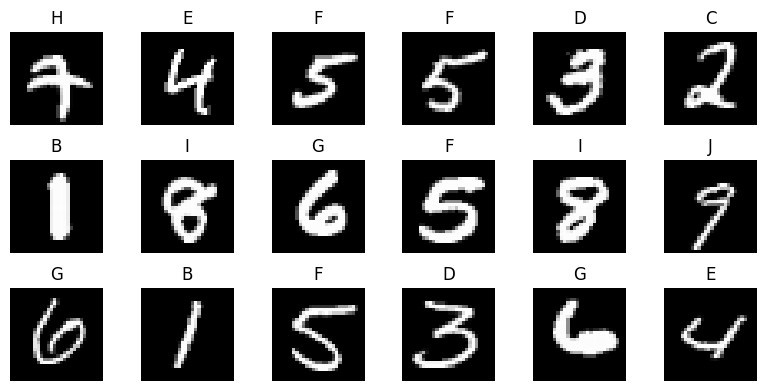

In [21]:
batch = next(iter(train_loader))
images, labels = batch
print(images.shape, labels.shape)

fig, axes = plt.subplots(3, 6, figsize=(8, 4))
for ax, img, label in zip(axes.ravel(), images[:18], labels[:18]):
    ax.imshow(img.squeeze(0), cmap="gray")
    ax.set_title(chr(ord("A") + label.item()))
    ax.axis("off")

plt.tight_layout()
plt.show()

torch.Size([128, 1, 28, 28]) torch.Size([128])


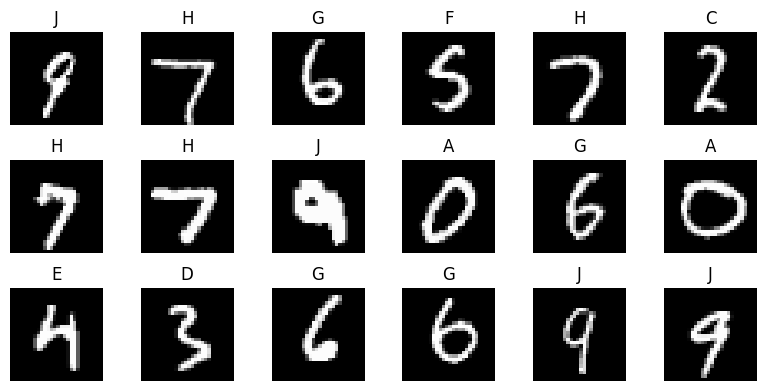

In [22]:
batch = next(iter(train_loader))
images, labels = batch
print(images.shape, labels.shape)

fig, axes = plt.subplots(3, 6, figsize=(8, 4))
for ax, img, label in zip(axes.ravel(), images[:18], labels[:18]):
    ax.imshow(img.squeeze(0), cmap="gray")
    ax.set_title(chr(ord("A") + label.item()))
    ax.axis("off")

plt.tight_layout()
plt.show()

In [23]:
from torch import nn, optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [24]:
def run_epoch(model, loader, criterion, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.set_grad_enabled(train):
        for images, labels in tqdm(loader, leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


for epoch in range(3):  # demo: 3 epochs
    train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, train=True)
    val_loss, val_acc = run_epoch(model, val_loader, criterion, optimizer=None, train=False)
    print(
        f"Epoch {epoch + 1} "
        f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
        f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}"
    )

Epoch 1 Train loss: 0.1856, acc: 0.9436 | Val loss: 0.0546, acc: 0.9843


Epoch 2 Train loss: 0.0681, acc: 0.9797 | Val loss: 0.0516, acc: 0.9843


Epoch 3 Train loss: 0.0512, acc: 0.9842 | Val loss: 0.0501, acc: 0.9857


In [25]:
test_loss, test_acc = run_epoch(model, test_loader, criterion, optimizer=None, train=False)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

Test loss: 0.0372, Test acc: 0.9876


In [26]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "num_classes": num_classes,
        "split": "letters",
    },
    "../models/emnist_letters_cnn_notebook.pth"
)